Research article: https://www.sciencedirect.com/science/article/pii/S2352340922001597  
Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE18870  
**Nội dung**: Phân tích MA-plot từ dữ liệu RNA-seq của tế bào ung thư vú MCF-7 điều trị bằng G1 - tác nhân kích hoạt receptor estrogen liên kết protein G (GPER).  
**Mục tiêu của phân tích**: so sánh sự thay đổi biểu hiện gene giữa nhóm treat (điều trị) và control (đối chứng), giúp nhận diện các gene thay đổi biểu hiện giữa các nhóm, từ đó chỉ ra các biến thể gene tiềm năng để nghiên cứu thêm về tác động của GPER trong ung thư vú.

Thêm các thư viện cần thiết

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

Tạo môi trường để dùng R trong Jupyter Notebook

In [56]:
import re
import os 
os.environ['R_HOME'] =r"C:\Program Files\R\R-4.5.1"
os.environ['PATH'] += r" ;C:\Program Files\R\R-4.5.1\bin"
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Chỉnh chất lượng hình ảnh bằng matplotlib 

In [99]:
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] =300
def output_figure(n):
    plt.savefig(f'figure_output/{n}.svg', dpi =300, bbox_inches ='tight')

Đưa dữ liệu gene counts từ file Excel vào DataFrame

In [58]:
data = pd.read_excel(r"C:\Users\HP\Downloads\GSE216876_Raw_gene_counts_matrix_enterolactone_DMSO.xlsx")
data
            

,Geneid,MC72_1,MC72_2,MC72_5,MEL72_2,MEL72_4,MEL72_5
0,ENSG00000223972,6,2,8,15,8,5
1,ENSG00000227232,60,32,35,44,33,39
2,ENSG00000278267,6,4,2,4,4,4
3,ENSG00000243485,0,0,0,4,0,1
4,ENSG00000284332,0,0,0,0,0,0
...,...,...,...,...,...,...,...
58730,ENSG00000271254,249,116,181,221,102,230
58731,ENSG00000275405,2,0,1,0,0,0
58732,ENSG00000275987,0,0,0,0,0,0
58733,ENSG00000277475,0,0,0,2,0,1


Bảng thể hiện số reads count của từng gene trong các mẫu RNA-seq.  
Cột Geneid đại diện cho mã gene, các cột còn lại là số reads mapping vào gene đó ở từng mẫu thí nghiệm, đây là dữ liệu gốc để so sánh xem gene nào hoạt động mạnh hay yếu hơn giữa các nhóm mẫu.

 Thiết lập thư mục cài đặt package R và nạp thư viện DESeq2 để dùng cho phân tích biểu hiện khác biệt

In [59]:
%%R
lib_path <- Sys.getenv("R_LIBS_USER")
if (!dir.exists(lib_path)) dir.create(lib_path, recursive = TRUE)
.libPaths(lib_path)

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager", lib = lib_path)

BiocManager::install("DESeq2", lib = lib_path, update = FALSE, ask = FALSE)

library(DESeq2)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://mirror.chpc.utah.edu/pub/cran
Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13 ucrt)
Installing package(s) 'DESeq2'


Khai báo tên sample và tạo vector điều kiện thi nghiệm: ctrl : đối chứng, treat = xử lý

In [60]:
%%R
sample_names <- c("MC72_1","MC72_2", "MC72_5", "MEL72_2", "MEL72_4","MEL72_5")
condition <- c("ctrl","ctrl","ctrl","treat","treat","treat")

colData <- data.frame(
    row.names = sample_names,
    condition = factor(condition, levels =c("ctrl", "treat"))
)

colData

        condition
MC72_1       ctrl
MC72_2       ctrl
MC72_5       ctrl
MEL72_2     treat
MEL72_4     treat
MEL72_5     treat


In [51]:
print (data.columns.tolist())

['Geneid', 'MC72_1', 'MC72_2', 'MC72_5', 'MEL72_2', 'MEL72_4', 'MEL72_5']


Bỏ các dòng giá trị trùng lặp, không có giá trị và xuất sang R để phân tích với DESeq2

In [67]:
data_DE = data.drop_duplicates('Geneid').dropna(how='any')
%R -i data_DE

data_DE

,Geneid,MC72_1,MC72_2,MC72_5,MEL72_2,MEL72_4,MEL72_5
0,ENSG00000223972,6,2,8,15,8,5
1,ENSG00000227232,60,32,35,44,33,39
2,ENSG00000278267,6,4,2,4,4,4
3,ENSG00000243485,0,0,0,4,0,1
4,ENSG00000284332,0,0,0,0,0,0
...,...,...,...,...,...,...,...
58730,ENSG00000271254,249,116,181,221,102,230
58731,ENSG00000275405,2,0,1,0,0,0
58732,ENSG00000275987,0,0,0,0,0,0
58733,ENSG00000277475,0,0,0,2,0,1


Gán Geneid làm rownames cho count matrix

In [68]:
%%R
rownames(data_DE) <- data_DE$Geneid
data_DE$Geneid <- NULL

**Thực hiện phân tích DESeq2**  
Trong đó:  
32111 gene được xét có ít nhất 1 reads trở lên  
Tiêu chí lọc gene khác biệt biểu hiện dựa trên p-value đã hiệu chỉnh (FDR < 10%) cho kết quả:  
-1015 gene (3,2%) tăng biểu hiện với nhóm điều trị (LFC > 0), cho thấy G1 có tác dụng làm tăng sự biểu hiện của một nhóm gene nhất định.  
-642 gene (2%) giảm biểu hiện với nhóm điều trị (LFC < 0), phản ánh một số gene bị ức chế hoặc giảm hoạt động khi bị điều trị bằng G1.  
-Không có gen ngoại lai (outliner) trong quá trình phân tích, điều này cho thấy sự ổn định và chất lượng của bộ dữ liệu thu được từ RNA-seq.  
-> Trong 32,111 gene, có khoảng 1,657 gene (5.2%) được xác định là khác biệt biểu hiện có ý nghĩa thống kê (DEGs)  


In [71]:
%%R
dds <- DESeqDataSetFromMatrix(
    countData = data_DE,
    colData = colData,
    design = ~ condition
)
dds <- DESeq(dds)
res <- results(dds)
summary(res)


out of 32111 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1015, 3.2%
LFC < 0 (down)     : 642, 2%
outliers [1]       : 0, 0%
low counts [2]     : 17862, 56%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Biểu đồ MA-plot trực quan hóa sự thay đổi biểu hiện giữa nhóm treat và control.  
Trục X: Mean of normalized counts – Thể hiện mức độ biểu hiện trung bình của gen trong tất cả các mẫu (cả nhóm treat và control).  
Trục Y: log2 fold change – Thể hiện sự thay đổi biểu hiện giữa nhóm điều trị và nhóm đối chứng. Nếu giá trị log2 fold change lớn hơn 0, có nghĩa là gene tăng biểu hiện trong nhóm điều trị, còn nếu nhỏ hơn 0 thì gene giảm biểu hiện.

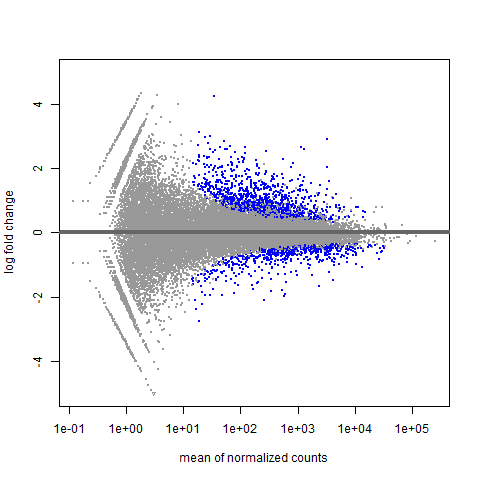

In [73]:
%%R
plotMA(res, ylim = c(-5,5))

**Kết quả từ MA-plot:**    
Các điểm xám: Đại diện cho gene không có sự thay đổi biểu hiện có ý nghĩa thống kê giữa nhóm điều trị và nhóm đối chứng.  
Các điểm xanh: Đại diện cho các gene có sự thay đổi biểu hiện vượt qua ngưỡng kiểm định và cho thấy những biến đổi liên quan đến tác động của G1 trên tế bào ung thư vú.  
Tính đối xứng của MA-plot: Biểu đồ không cho thấy sự lệch lớn trong sự thay đổi giữa hai nhóm chứng tỏ sự thay đổi biểu hiện đồng đều giữa các gene.  
    

**Kết luận:**  
Sự thay đổi biểu hiện gene: Việc điều trị tế bào MCF-7 bằng G1 dẫn đến sự thay đổi rõ rệt biểu hiện của một số gene khiến chúng bị ức chế hoặc tăng biểu hiện đã chứng minh GPER có tác động đến tế bào ung thư vú, mở ra những hướng nghiên cứu mới về phương pháp điều trị ung thư dựa trên sự điền hòa GPER.  
Các gene vượt ngưỡng kiểm định là các đối tượng xác định nghiên cứu để cải thiện phương pháp chẩn đoán và điều trị ung thư vú.   
**Hướng nghiên cứu đề xuất:**  
Nghiên cứu và thử nghiệm lâm sàng để kiểm chứng các gene mục tiêu được phát hiện trong nghiên cứu này để xác nhận hiệu quả điều trị của các liệu pháp nhắm đến GPER đối với ung thư vú, mở ra hướng điều trị mới trong y học.